import all the necesarry library

In [1]:
import numpy as np
import pywt
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math
from scipy.fftpack import dct
from scipy.fftpack import idct

from typing import List
import hashlib
import struct

The Frequency-Flipping methode use 2 DCT coefficient location that are expected to have comparable average value for the DCT normalization matrix 8x8. 

In the DCT normalization matrix of size 8x8, the coefficient at (0,0) has a value of $\frac{1}{\sqrt{2}}$ and the coefficients at (0,1) and (1,0) have a value of $\frac{1}{2}$. 

Therefore, any pair of coefficients at locations `(i,j)` and `(k,l)` where `i+j = k+l` and i,j,k,l are **not equal to 0 or 1** can be expected to have comparable average values. 

(For example, the coefficients at (2,6) and (6,2) or (3,5) and (5,3))

In [2]:
# Différence de valeur des coeff de la DCT de l'image 
maxVal = 20 # recomendation : 1 à 50 
""" 0-8 -> coefficient des bloc 8x8 de la DCT à utiliser
Par défaut :
C(4,1) >  C(2,3) --> 0
C(4,1) <= C(2,3) --> 1
"""
C1x, C1y = 4, 1 
C2x, C2y = 2, 3
password = "my_password"

# Taille de la matrice utilisée pour la marque 
x = 2 # Divise la taille de la marque
# Taille de l'image/2/8/x -> Dct2D/Bloc8x8/x

# Chemin des images
image = "original/leopard.jpg"
marque = "original/marque/dragon2.jpg"
result = "result/watermarkedImage.jpg"

# Texte à insérer
texte = "Le tatouage numérique (digital watermark, « filigrane numérique ») est une technique permettant d'ajouter des informations +++ les textes trop longs sont automatiquement coupés"
#texte = "Test d'insertion de text  !"

# Mode debug
np.set_printoptions(threshold=np.inf)

# Functions 

Function Convert and resize image 

In [3]:
def convertImage(imageName):
    # Read the image and convert it to RGB
    img = cv2.imread(imageName)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get the image dimensions and resize it if necessary
    height, width = img.shape[:2]
    # Resize to have minimum 2048 in width or height with the ratio of the original image
    if height < 2048 and width < 2048:
        if height > width:
            width = math.ceil(width*2048/height)
            height = 2048
        else:
            height = math.ceil(height*2048/width)
            width = 2048   
        img = cv2.resize(img, (width, height))         
        
    if height % 8 != 0 or width % 8 != 0:
        height = math.ceil(height/8)*8
        width = math.ceil(width/8)*8
        img = cv2.resize(img, (width, height))
    
    # Convert the RGB image to YCbCr and split it into its three channels
    imgC = Image.fromarray(img)
    imgYCbCr = imgC.convert('YCbCr')
    Y, Cb, Cr = imgYCbCr.split()
    
    # Convert the Y channel to a numpy array
    imageArray = np.array(Y.getdata(), dtype=float).reshape((imgYCbCr.size[1], imgYCbCr.size[0]))
    
    # Return the numpy array, the color channels, and the image dimensions
    return imageArray, (Y, Cb, Cr), (width, height)


# Convert the image to binary image of 1:1 less or equal to Msize
def convertMark(imageName, Msize):
    img = cv2.imread(imageName, cv2.IMREAD_GRAYSCALE)
    size = img.shape
    # If it not already Look for the nearest multiple of 8 for height and width
    if size[0] % 8 != 0 or size[1] % 8 != 0:
        size = (math.ceil(size[1]/8)*8, math.ceil(size[0]/8)*8)
    # Check if the image is not too big for the matrix M
    if size[0] > Msize[0] or size[1] > Msize[1]:
        # Search the size for the image to be equal or less than the matrix M size with a ratio of 1
        if size[0] > Msize[0]:
            size = (Msize[0], Msize[0])
        if size[1] > Msize[1]:
            size = (Msize[1], Msize[1])
            
    # Resize the image
    img = cv2.resize(img, size)
    
    # Converting the gray scale image to binary image
    img = cv2.threshold(img, 128, maxVal, cv2.THRESH_BINARY)[1]
    markArray = np.array(img, dtype=float).reshape((size[0], size[1]))
    return markArray

Convert text

In [4]:
def utf8_to_binary(text: str):
    # Convert the text to a bytearray in UTF-8 encoding
    byte_array = bytearray(text.encode("utf-8"))

    # Convert each byte to binary and concatenate them into a string
    binary_string = "".join(f"{byte:08b}" for byte in byte_array)
    return binary_string
                          

def binary_list_to_utf8(binary_list: List[int]) -> str:
    # Inverse the conversion of 1 to 255 and 0 to 0
    binary_list = [0 if x < 1 else 1 for x in binary_list]
    # Convert the binary list to a binary string
    binary_string = "".join(map(str, binary_list))
    # Convert the binary string to a bytearray and then to a string in UTF-8 encoding
    byte_array = bytearray(int(binary_string[i:i+8], 2) for i in range(0, len(binary_string), 8))
    # Convert the binary string to a bytearray and then to a string in UTF-8 encoding,
    # replacing unknown characters with a dash
    try:
        byte_array = bytearray(int(binary_string[i:i+8], 2) for i in range(0, len(binary_string), 8))
        text = byte_array.decode("utf-8", errors="strict")
    except UnicodeDecodeError as e:
        byte_array = bytearray(int(binary_string[i:i+8], 2) if binary_string[i:i+8] != "00000000" else 45 for i in range(0, len(binary_string), 8))
        text = byte_array.decode("utf-8", errors="replace")
    return text

Function that embedded watermark image into cover image

In [5]:
# Embed watermark into the cover image with frequency-flipping method
""" 
C1 >  C2 --> 0
C1 <= C2 --> 1
"""

def embedWatermark(watermarkArray, pixel_positions, originalImage):
    watermarkFlat = watermarkArray.ravel() # ravel() is used to convert 2D array to 1D array
    ind = 0
    for x, y in pixel_positions:
        if ind < len(watermarkFlat):
            subdct = originalImage[x*8:x*8+8, y*8:y*8+8]
            # Check if the pixel is 0 or 255
            if watermarkFlat[ind] == 0:
                # If the pixel is 0 we want C1 > C2
                if subdct[C1x][C1y] < subdct[C2x][C2y]+maxVal:
                    # Flip the frequency and add the maxVal
                    subdct[C1x][C1y], subdct[C2x][C2y] = subdct[C2x][C2y], subdct[C1x][C1y]
                    if subdct[C1x][C1y] < subdct[C2x][C2y]+maxVal*10:
                        subdct[C1x][C1y] += maxVal
                        subdct[C2x][C2y] -= maxVal
            else:
                if subdct[C1x][C1y] >= subdct[C2x][C2y]-maxVal:
                    # Flip the frequency
                    subdct[C1x][C1y], subdct[C2x][C2y] = subdct[C2x][C2y], subdct[C1x][C1y]
                    if subdct[C1x][C1y] >= subdct[C2x][C2y]-maxVal*10:
                        subdct[C1x][C1y] -= maxVal
                        subdct[C2x][C2y] += maxVal
            originalImage[x*8:x*8+8, y*8:y*8+8] = subdct
            ind += 1
    return originalImage   

Function that apply Discrete Cosine Transform on an 8x8 block

In [6]:
# DCT transform on image, i.e. image array
def applyDCT(imageArray):
    rows, cols = imageArray.shape
    allSubdct = np.empty((rows, cols))
    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            subpixels = imageArray[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            allSubdct[i:i+8, j:j+8] = subdct
    return allSubdct

Function that apply Inverse Discrete Cosine Transform on an 8x8 block

In [7]:
def inverseDCT(allSubdct):
    rows, cols = allSubdct.shape
    allSubidct = np.empty((rows, cols))
    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            subidct = idct(idct(allSubdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            allSubidct[i:i+8, j:j+8] = subidct
    return allSubidct

Function that extract watermark image from embedded image

In [8]:
# Get watermark from the cover image with frequency-flipping method
def getWatermark(dctWatermarkedCoeff, pixel_positions, watermarkSize=None):
    subwatermarks = []
    for x, y in pixel_positions:
        coeffSlice = dctWatermarkedCoeff[x*8:x*8+8, y*8:y*8+8]
        if coeffSlice[C1x][C1y] > coeffSlice[C2x][C2y]:
            subwatermarks.append(0)
        else:
            subwatermarks.append(1)
    if watermarkSize is None: # For the text watermark
        return subwatermarks
    watermark = np.array(subwatermarks).reshape(watermarkSize, watermarkSize) 
    watermark = watermark * 255   
    return watermark

In [9]:
# Original fonction (41s for 128x128)
def password_to_positionA(password, nbCoords):
    size = int(math.sqrt(nbCoords)) 
    width, height = 128, 128
    len_x = (width - 1).bit_length()    # required bits to code x coordinates of image
    len_y = (height - 1).bit_length()   # required bits to code y coordinates of image

    password_bytes = password.encode('utf-8')

    pwHash = hashlib.sha256(password_bytes).digest()
    binary_string = "{:08b}".format(int(pwHash.hex(),16))

    coords = []
    j = 0
    x = int(binary_string[j:j+len_x], 2) % width
    j += len_x
    y = int(binary_string[j:j+len_y], 2) % height
    j += len_y
    coords.append((x, y))
    for i in range(nbCoords - 1):
        while (x, y) in coords:
            x = int(binary_string[j:j+len_x], 2) % width
            j += len_x
            y = int(binary_string[j:j+len_y], 2) % height
            j += len_y
            if j + len_x + len_y > len(binary_string):
                pwHash = hashlib.sha256(pwHash).digest()
                binary_string = "{:08b}".format(int(pwHash.hex(),16))
                j = 0
        coords.append((x, y))
    return coords


# Optimized version 1 (26s for 128x128)
def password_to_position2(password, nbCoords):
    width, height = 128, 128
    max_coord = width * height
    len_x = (width - 1).bit_length()    # required bits to code x coordinates of image
    len_y = (height - 1).bit_length()   # required bits to code y coordinates of image
    mask_x = 2 ** len_x - 1
    mask_y = 2 ** len_y - 1

    password_bytes = password.encode('utf-8')
    pwHash = hashlib.sha256(password_bytes).digest()
    j = 0
    x, y = struct.unpack_from('<2I', pwHash, j)
    j += struct.calcsize('<2I')
    x = x % width
    y = y % height

    coords = [(x, y)]
    for i in range(nbCoords - 1):
        while (x, y) in coords:
            if j + struct.calcsize('<2I') > len(pwHash):
                pwHash = hashlib.sha256(pwHash).digest()
                j = 0
            x, y = struct.unpack_from('<2I', pwHash, j)
            j += struct.calcsize('<2I')
            x = x % width
            y = y % height
        coords.append((x, y))

    return coords

# Optimisation version 2 (11s for 128x128)
def password_to_position(password, Msize, nbCoords):
    width, height = Msize[0], Msize[1]
    #nbCoords = width * height
    max_coord = width * height
    # required bits to code x,y coordinates of image
    len_x = (width - 1).bit_length()
    len_y = (height - 1).bit_length()
    # Mask for bitwise AND operations instead of modulo operations
    mask_x = 2 ** len_x - 1
    mask_y = 2 ** len_y - 1

    password_bytes = password.encode('utf-8')
    pwHash = hashlib.sha256(password_bytes).digest()
    j = 0

    coords = []
    while len(coords) < nbCoords:
        if j + 8 > len(pwHash):
            pwHash = hashlib.sha256(pwHash).digest()
            j = 0
        # <2I for 2 unsigned 32-bit integers in little-endian format.
        x, y = struct.unpack_from('<2I', pwHash, j) 
        j += 8
        x, y = x & mask_x, y & mask_y
        index = (x + y * width) % max_coord
        if index not in coords:
            coords.append(index)

    return [(i % width, i // width) for i in coords]



def generate_coordinates(Msize, nbCoords):
    width, height = Msize
    coords = []
    x, y = 0, 0
    for i in range(int(nbCoords)):
        coords.append((x, y))
        x += 1
        if x == width:
            x = 0
            y += 1
        if y == height:
            break
    return coords


Function for save image

In [10]:
def printImage(imageArray, name):
    imageArrayCopy = imageArray.clip(0, 255)
    imageArrayCopy = imageArrayCopy.astype("uint8")
    img = Image.fromarray(imageArrayCopy)
    img.save('result/' + name)

Function that recover watermark image using 2 key

In [11]:
def recoverWatermark(image, password, outputImageName=None, Wsize=None):
    # Get the necessary parameters :
    imageArray, colors, size = convertImage(image)
    Isize = (int(size[1]/2/8), int(size[0]/2/8)) # Available space for watermark
    if Wsize != None:
        nbCoords = Wsize[0] * Wsize[1]
    else:
        # Size of the watermark square
        Wsize = (int(Isize[0]/x), int(Isize[1]/x)) 
        # Compare width and height of Msize and multiply the smallest
        if Wsize[0] < Wsize[1]:
            nbCoords = Wsize[0] * Wsize[0]
        else:
            nbCoords = Wsize[1] * Wsize[1]
    Wlength = int(np.sqrt(nbCoords))
    
    # Start the recovery process :
    coeffsWatermarkedImage=list(pywt.wavedec2(data = imageArray, wavelet = 'haar', level = 1))
    dctWatermarkedCoeff = applyDCT(coeffsWatermarkedImage[0])
    
    pixel_positions = password_to_position(password, Isize, nbCoords)
    #pixel_positions = generate_coordinates(Isize, nbCoords)
    
    watermarkArray = getWatermark(dctWatermarkedCoeff, pixel_positions, Wlength)

    watermarkArray =  np.uint8(watermarkArray)
    #watermarkArray = jpegCorrection(watermarkArray)
    
    #Save result
    if outputImageName != None:
        printImage(watermarkArray, outputImageName)
    else:
        printImage(watermarkArray, 'recoveredWatermark.png')
    return watermarkArray



def recoverText(image, password, nbChr=None):
    # Get the necessary parameters :
    imageArray, colors, size = convertImage(image)
    Isize = (size[1]//16, size[0]//16) # Available space for watermark
    Wsize = [Isize[0]//x, Isize[1]//x] # Watermark size
    print("Wsize before %8", Wsize)

    if nbChr is not None:
        nbCoords = nbCoords * 8
    else:
        """ # Size of the watermark square multiple of 8 
        while int(Wsize[0]) % 8 != 0:
            Wsize[0] -= 1
        while int(Wsize[1]) % 8 != 0:
            Wsize[1] -= 1 """
        nbCoords = Wsize[0] * Wsize[1]
        
    
    # Start the recovery process :
    coeffsWatermarkedImage=list(pywt.wavedec2(data = imageArray, wavelet = 'haar', level = 1))
    dctWatermarkedCoeff = applyDCT(coeffsWatermarkedImage[0])
    
    print("Size Image", size, imageArray.shape)
    print("dct coeff", dctWatermarkedCoeff.shape)
    print("Isize", Isize)
    print("x", x)
    print("Wsize", Wsize)
    print("nbCoords", nbCoords)
    
    pixel_positions = password_to_position(password, Isize, nbCoords)
    #pixel_positions = generate_coordinates(Isize, nbCoords)

    print("pixel positions", len(pixel_positions))
    
    watermarkArray = getWatermark(dctWatermarkedCoeff, pixel_positions, None)
    # If the watermark is not in list format convert it
    if type(watermarkArray) != list:
        watermarkArray = [int(j) for j in watermarkArray.flatten()] 
    watermarkArray = binary_list_to_utf8(watermarkArray)
    
    # Look for dash in the text to know where the watermark ends if 3 dashes are found next to each other cut the text
    dashCount = 0
    for i in range (0, len(watermarkArray)-1, 1):
        if watermarkArray[i] == '-':
            dashCount += 1
        else:
            dashCount = 0
        if dashCount == 3:
            watermarkArray = watermarkArray[:i-2]
            break
        
    #Save result in txt file
    else :
        file = open('result/recoveredText.txt', 'w')
        file.write(watermarkArray)
        file.close()
    return watermarkArray

Function that embedded watermark image into cover image

In [12]:
def embeddedImage(coverImage, watermarkImage, password): #Todo
    imageArray, colors, size = convertImage(coverImage)
    Isize = (int(size[1]/2/8), int(size[0]/2/8)) # Available space for watermark
    Wsize = (int(size[1]/2/8/x), int(size[0]/2/8/x)) # Watermark size
    watermarkArray = convertMark(watermarkImage, Wsize)
    nbCoords = watermarkArray.shape[0] * watermarkArray.shape[1]
    pixel_positions = password_to_position(password, Isize, nbCoords)
    #pixel_positions = generate_coordinates(Isize, nbCoords)

    coeffsImage = list(pywt.wavedec2(data=imageArray, wavelet = 'haar', level = 1))
    dctArray = applyDCT(coeffsImage[0]) # [0] corresponds to cH subband (cH = LH)    

    dctArray = embedWatermark(watermarkArray, pixel_positions, dctArray)

    coeffsImage[0] = inverseDCT(dctArray)
    imageArrayH=pywt.waverec2(coeffsImage, 'haar')
    
    # Get Y Cb Cr channels
    y, Cb, Cr = colors
    # Convert the numpy array back to an image
    y = Image.fromarray(imageArrayH.astype('uint8'))
    # Put the red channel back in the RGB image
    colors = (y, Cb, Cr)
    
    # Merge the YCbCr channels back into a single image
    img = Image.merge('YCbCr', colors).convert('RGB')
    
    # Save result
    img.save('result/watermarkedImage.jpg')
    #img.save('result/watermarkedImage.png')
    
    return img


def embeddedTexte(coverImage, texte, password):
    texte = texte + '---'
    Tsize = int((len(texte)+7)*8)
    imageArray, colors, size = convertImage(coverImage)
    Isize = (int(size[1]/2/8), int(size[0]/2/8)) # Available space for watermark
    
    # Maximal size of the text
    nbCoords = (Isize[0]/x)*(Isize[1]/x)
    if Tsize > nbCoords:
        Tsize = nbCoords
    
    texteArray = utf8_to_binary(texte)
    # Convert string to list of characters
    charList = list(texteArray)
    # Convert list of characters to numpy array of int64
    intArray = np.array(charList, dtype=np.int64)
    
    print("Size Image", size, imageArray.shape)

    pixel_positions = password_to_position(password, Isize, Tsize)
    #pixel_positions = generate_coordinates(Isize, Tsize)
    
    coeffsImage = list(pywt.wavedec2(data=imageArray, wavelet = 'haar', level = 1))
    dctArray = applyDCT(coeffsImage[0])
    
    
    print("dct coeff", dctArray.shape)
    print("Isize", Isize)
    print("x", x)
    print("nbCoords", Tsize)
    print("pixel positions", len(pixel_positions))
    
    dctArray = embedWatermark(intArray, pixel_positions, dctArray)

    coeffsImage[0] = inverseDCT(dctArray)
    imageArrayH=pywt.waverec2(coeffsImage, 'haar')
    
    # Get Y Cb Cr channels
    y, Cb, Cr = colors
    # Convert the numpy array back to an image
    y = Image.fromarray(imageArrayH.astype('uint8'))

    # Put the red channel back in the RGB image
    colors = (y, Cb, Cr)

    # Save result
    img = Image.merge('YCbCr', colors).convert('RGB')
    img.save('result/watermarkedImage.jpg')
    #img.save('result/watermarkedImage.png')
    
    return img

# Testing

In [13]:
watermarkeImage = embeddedImage(image,marque, password) 
#watermarkeImage = embeddedTexte(image,texte, password)

In [14]:
watermarkArray = recoverWatermark("result/watermarkedImage.jpg", password) # Wsize=(x, y) for specific mark
#watermarkArray = recoverText(result, password)
print(watermarkArray)

[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 25

# Plot all three resultant image

Wlength =  107


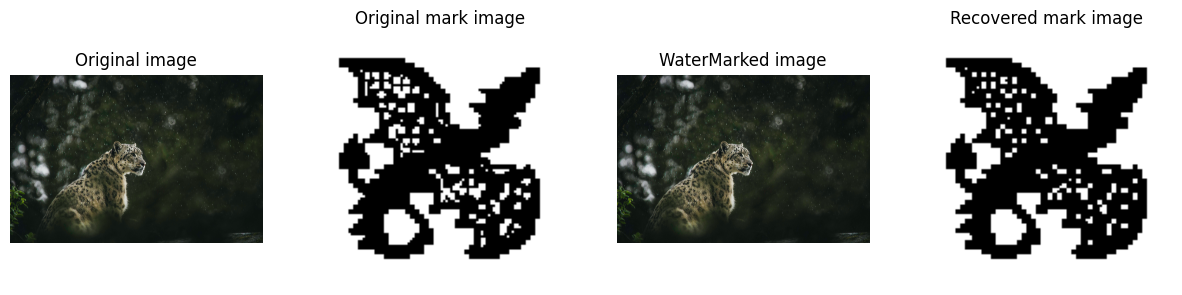

In [15]:
# Get the size of the mark
imageArray, colors, size = convertImage(result)
Msize = (int(((size[1]/2)/8)/x), int(((size[0]/2)/8)/x)) # DCT + Block + random

# Compare width and height of Msize and multiply the smallest
if Msize[0] < Msize[1]:
    nbCoords = Msize[0] * Msize[0]
else:
    nbCoords = Msize[1] * Msize[1]
Wlength = int(np.sqrt(nbCoords))
print("Wlength = ", Wlength)


# Image used for cover :
_, readImage, _ = convertImage(image)
readImage = Image.merge('YCbCr', readImage).convert('RGB')
readImage = np.array(readImage)
# Image used for watermark :
marqueImg = Image.open(marque).resize((Wlength, Wlength), 1)
marqueImg = marqueImg.convert('L')
marqueImg = marqueImg.point(lambda x: 0 if x < 128 else 255, '1')

# Result watermarked image :
waterimg = cv2.imread("result/watermarkedImage.jpg")
waterimg = cv2.cvtColor(waterimg, cv2.COLOR_BGR2RGB)
# Result recovered watermark :
recovwater = cv2.imread("result/recoveredWatermark.png", cv2.IMREAD_GRAYSCALE)

# Display results
plt.figure(figsize = (15,15))
plt.subplot(1,4,1),plt.imshow(cv2.cvtColor(readImage, 1)),plt.title("Original image"), plt.axis('off')
plt.subplot(1,4,2),plt.imshow(marqueImg),plt.title("Original mark image"), plt.axis("off")
plt.subplot(1,4,3),plt.imshow(cv2.cvtColor(waterimg, 1)),plt.title("WaterMarked image"), plt.axis("off")
plt.subplot(1,4,4),plt.imshow(recovwater, cmap = 'gray'),plt.title("Recovered mark image"), plt.axis("off")
plt.show()

- Image :
Mean of difference : 1.6170198200914392 
Max of difference  : 226 
Number of different pixels : 13927583  -->  39406177 / 53333760 = 73.88 % unchanged

- Mark :
Mean of difference : 249.89955454624857 
Max of difference  : 255 
Number of different pixels : 229  -->  11220 / 11449 = 97.99 % unchanged


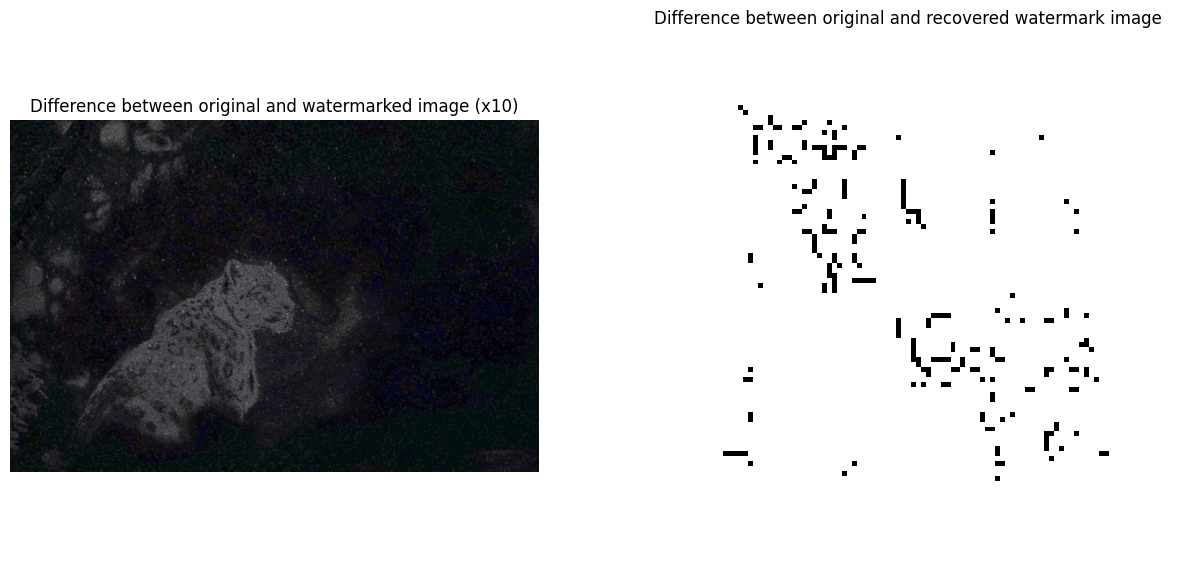

In [16]:
# Resize original image to the same size as watermarked image
#readImageModif = cv2.resize(readImage, (2048, 2048))
# Convert recovered watermark from numpy.ndarray to PIL.Image
#recovwaterImg = Image.fromarray(recovwater)

# Convert marqueImg from binary PIL to numpy array
marqueNp = np.array(marqueImg)
# Convert True to 1 and False to 0
marqueNp = np.where(marqueNp == True, 255, 0)
marqueNp = np.array(marqueNp, dtype = np.uint8)
# Invert the image
marqueNp = cv2.bitwise_not(marqueNp)

# Compute and Plot difference between original and watermarked image
diffimg = cv2.absdiff(readImage, waterimg)
diffmark = cv2.absdiff(marqueNp, recovwater)

# Number of different pixels
pixelimg = np.where(diffimg > 0, 1, 0)
pixelmark = np.where(diffmark > 0, 1, 0)

print("- Image :\nMean of difference :", str(np.mean(diffimg)), "\nMax of difference  : " + str(np.max(diffimg)), 
      "\nNumber of different pixels :", str(np.size(diffimg)-np.sum(pixelimg)), " --> ", str(np.sum(pixelimg)), "/", str(np.size(diffimg)), "=", str(np.sum(pixelimg)/np.size(diffimg)*100)[:5], "% unchanged")
print("\n- Mark :\nMean of difference :", str(np.mean(diffmark)), "\nMax of difference  :", str(np.max(diffmark)), 
      "\nNumber of different pixels :", str(np.size(diffmark)-np.sum(pixelmark))," --> ", str(np.sum(pixelmark)), "/", str(np.size(diffmark)), "=", str(np.sum(pixelmark)/np.size(diffmark)*100)[:5], "% unchanged")

plt.figure(figsize = (15,15))
plt.subplot(1,2,1),plt.imshow(cv2.cvtColor(diffimg*15, 1)),plt.title("Difference between original and watermarked image (x10)"), plt.axis("off")
plt.subplot(1,2,2),plt.imshow(cv2.cvtColor(diffmark, cv2.COLOR_BGR2RGB)),plt.title("Difference between original and recovered watermark image"), plt.axis("off")
plt.show()

---

# Calculate PSNR value

In [17]:
def pastingImage (img1, img2):
    temp = img2.copy()
    x_offset=y_offset=50
    img2[y_offset:y_offset+img1.shape[0], x_offset:x_offset+img1.shape[1]] = img1
    
    return img2, temp

In [18]:
def compute_psnr(img1, img2):
    
    img1 = img1.astype(float) / 255.
    img2 = img2.astype(float) / 255.
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return 10 * math.log10(1. / mse)

In [19]:
def NCC(img1, img2):
    return abs(np.mean(np.multiply((img1-np.mean(img1)),(img2-np.mean(img2))))/(np.std(img1)*np.std(img2)))

In [20]:
img1 = cv2.imread("original/image.jpg",0)
img1 = cv2.resize(img1, (512, 512))
img2 = cv2.imread("result/watermarkedImage.jpg",0)
img1, img2 = pastingImage(img1,img2)

psnr = compute_psnr(img1, img2)
print (f'PSNR value of resultant image is {psnr}')

PSNR value of resultant image is 27.211314485891155


In [21]:
print (f'Normalized cross correlation is {NCC(img1, img2)}')

Normalized cross correlation is 0.9328704839869056


# Attacks (Geometric & Signal Processing)

In [22]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 0
        #var = 0.001
        var = 0.05
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        #noisy = image + gauss
        noisy = image + image * gauss
        return noisy

    elif noise_typ == "s&p":
        row, col = image.shape[:2]  # get the row and column dimensions of the image
        s_vs_p = 0.5
        amount = 0.00003
        out = np.copy(image)

        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i, int(num_salt))
                    for i in image.shape[:2]]  # generate random coordinates for each dimension separately
        out[coords[0], coords[1]] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i, int(num_pepper))
                    for i in image.shape[:2]]  # generate random coordinates for each dimension separately
        out[coords[0], coords[1]] = 0

        return out

    elif noise_typ == "poisson":
        vals = len(np.unique(image)) 
        vals = 2 ** np.ceil(np.log2(vals))
        #noisy = np.random.poisson(image * vals) / float(vals) 
        noisy = np.random.poisson(image * vals) / float(vals) * 1.5
        return noisy
    elif noise_typ =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        #noisy = image + image * gauss
        noisy = image + image * gauss*0.25
        return noisy
    elif noise_typ == "rotate90" :
        angle = 90
        scale = 1.0
        w = image.shape[1]
        h = image.shape[0]
        rangle = np.deg2rad(angle)  # angle in radians
        nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
        nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale
        rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
        rot_move = np.dot(rot_mat, np.array(
            [(nw - w) * 0.5, (nh - h) * 0.5, 0]))
        rot_mat[0, 2] += rot_move[0]
        rot_mat[1, 2] += rot_move[1]
        noisy=cv2.warpAffine(image, rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))), flags=cv2.INTER_LANCZOS4)
        return noisy
    elif noise_typ=="chop30":
        img = image.copy()
        w, h = img.shape[:2]
        # chop off 30% of the top of the image
        #noisy=img[int(w * 0.3):, :] 
        # chop off 15% of the top of the image and 15% of the bottom
        noisy=img[int(w * 0.15):int(w * 0.85), :]
        return noisy
    
    elif noise_typ=="jpeg":
        # encode image as a jpeg with quality 50
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 45]
        result, encimg = cv2.imencode('.jpg', image, encode_param)
        # decode image
        decimg = cv2.imdecode(encimg, 1)
        decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
        decimg = cv2.cvtColor(decimg, cv2.COLOR_RGB2GRAY)
        return decimg


In [23]:
def restoreCrop(img, originalImage):
    # Add null information to the borders of a cropped image to make it 2048x2048 in size:
    # Get the dimensions of the cropped image
    height, width = img.shape

    # Create a new black image of the same size as readImage
    new_img = np.zeros((originalImage.shape[0], originalImage.shape[1]), dtype=np.uint8)
    
    # Calculate the position to place the cropped image in the center of the new image
    x_offset = (new_img.shape[1] - width) // 2
    y_offset = (new_img.shape[0] - height) // 2
    
    # Add the cropped image to the center of the new image
    new_img[y_offset:y_offset+height, x_offset:x_offset+width] = img

    return new_img

Without attack
			 PSNR de l'image : 40.3708480701206
			 PSNR de la marque : 2.0621302258377336



+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
				 Compression Attacks
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




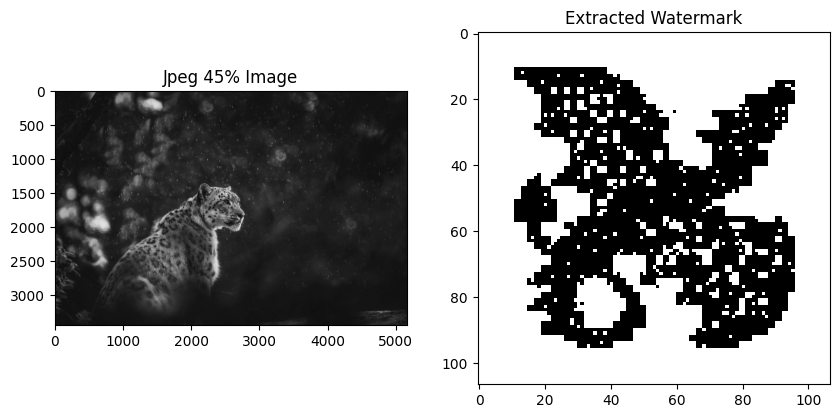

			 PSNR de l'image : 36.578942742112055
			 PSNR de la marque : 1.9549144172483521



+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
				 Geometric Attacks
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


				 Rotate 90°
-----------------------------------------------------------------------------------------


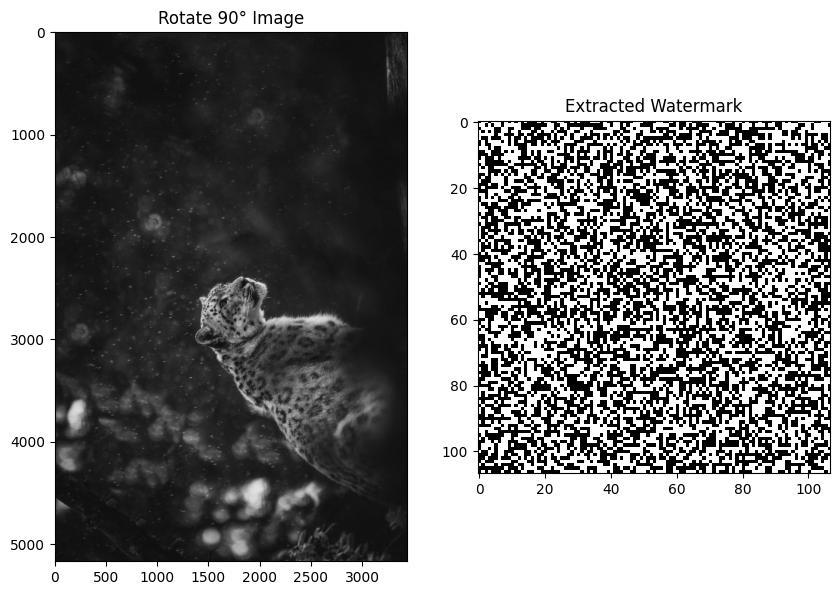

			 PSNR de la marque : 3.050761824795822
******************************************************************************************
				 Chop 30
-----------------------------------------------------------------------------------------


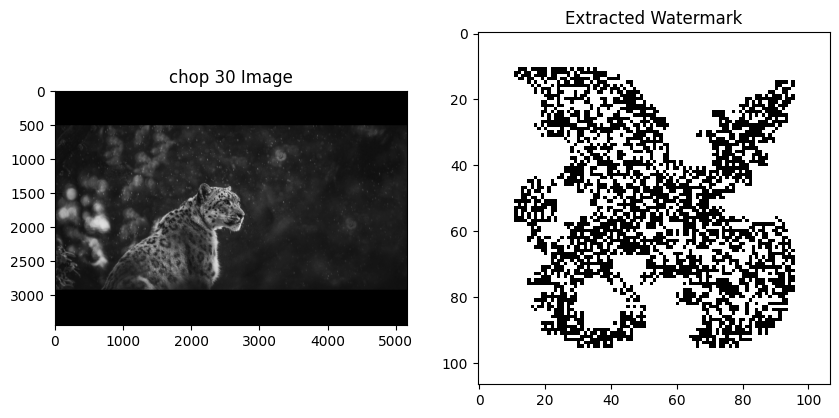

			 PSNR de l'image : 22.394415401941643
			 PSNR de la marque : 1.2041628232625308
******************************************************************************************



+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
				 Image Filtering Attacks
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


				 Gaussian Noise 
-----------------------------------------------------------------------------------------


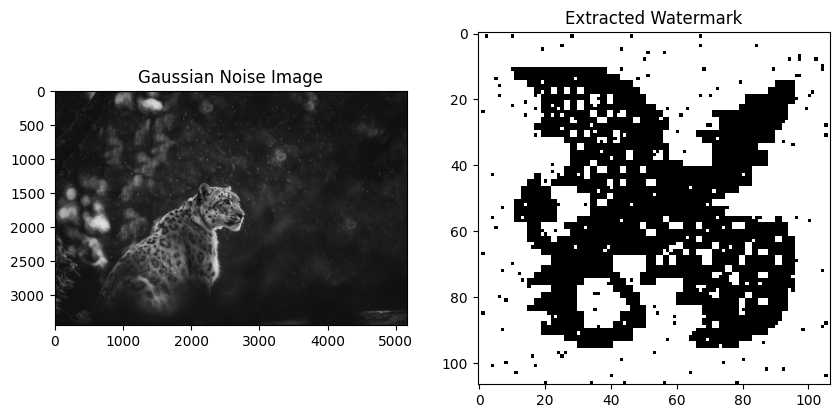

			 PSNR de l'image : 27.295898210207756
			 PSNR de la marque : 2.10688697551374
******************************************************************************************
				 Salt and Pepper Noise
-----------------------------------------------------------------------------------------


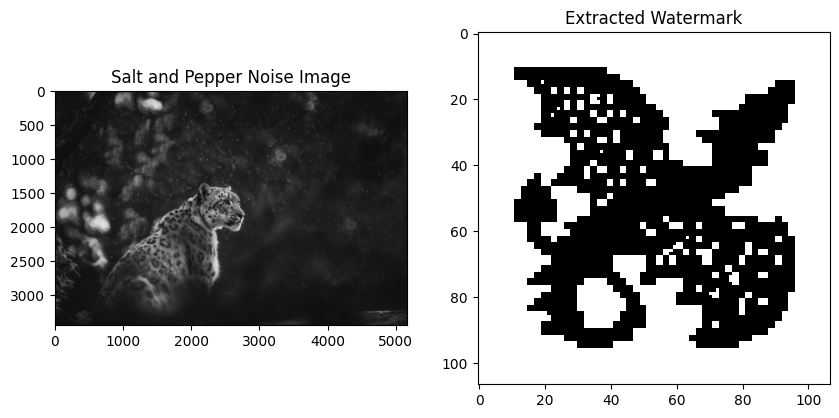

			 PSNR de l'image : 40.32481784882319
			 PSNR de la marque : 2.0621302258377336
******************************************************************************************
				 Poisson Noise
-----------------------------------------------------------------------------------------


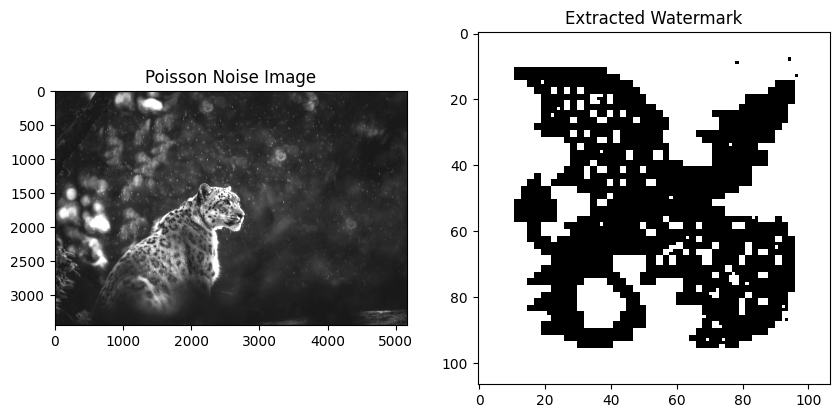

			 PSNR de l'image : 20.536817552674368
			 PSNR de la marque : 2.0560120265726987
******************************************************************************************
				 Speckle Noise
-----------------------------------------------------------------------------------------


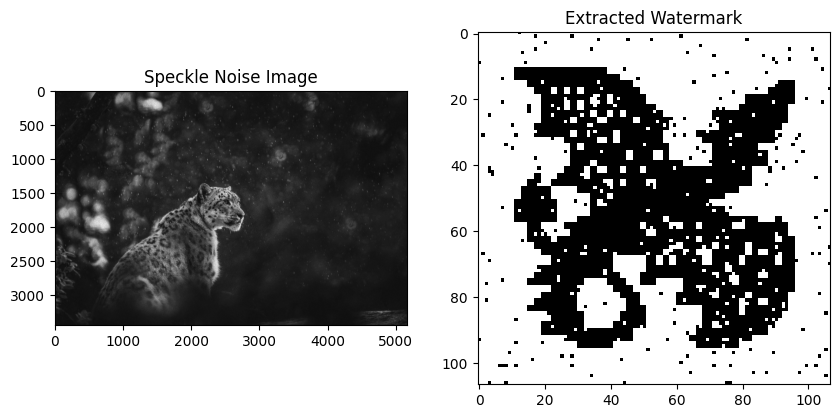

			 PSNR de l'image : 26.36363970950668
			 PSNR de la marque : 2.098090600255035
******************************************************************************************


In [24]:
originalImage = readImage
originalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
originalMarque = np.array(marqueImg, dtype=np.uint8)
watermarked = waterimg
watermarked = cv2.cvtColor(watermarked, cv2.COLOR_BGR2GRAY)

""" watermarked = embeddedImage(image,marque) 
# Convert to numpy and grayscale
watermarked = np.array(watermarked)
watermarked = cv2.cvtColor(watermarked, cv2.COLOR_BGR2GRAY) """

#extracted = cv2.imread("result/recoveredWatermark.png", cv2.IMREAD_GRAYSCALE)

print("Without attack")
extracted = recoverWatermark(result, 'my_password')
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,watermarked))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))

print("\n\n")
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print ('\t\t\t\t Compression Attacks')
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n')
img = noisy( "jpeg",watermarked)
cv2.imwrite("attack/jpeg.jpg", img) 
extracted = recoverWatermark("attack/jpeg.jpg", password, "jpeg.png")
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Jpeg 45% Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))

print("\n\n")
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print ('\t\t\t\t Geometric Attacks')
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n')

print ("\t\t\t\t Rotate 90°")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "rotate90",watermarked)
cv2.imwrite("attack/rotate90.jpg", img) 
extracted = recoverWatermark("attack/rotate90.jpg", password, "rotate90.png")
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Rotate 90° Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
#print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))

#print ("\t\t\t Normalized cross correlation de l'image :", NCC(pastingImage(originalImage,img),img))
#print ("\t\t\t Normalized cross correlation de l'image :", NCC(originalImage,img))
print ("******************************************************************************************")
print ("\t\t\t\t Chop 30")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "chop30",watermarked)
img = restoreCrop(img, originalImage)
cv2.imwrite("attack/chop30.jpg", img)
extracted = (recoverWatermark("attack/chop30.jpg", password, "crop.png")) # Image.fromarray(recoverWatermark(img))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("chop 30 Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))
#print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print("\n\n")
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print ('\t\t\t\t Image Filtering Attacks')
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n')

print ("\t\t\t\t Gaussian Noise ")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "gauss",watermarked)
cv2.imwrite("attack/gauss.jpg", img)
extracted = (recoverWatermark("attack/gauss.jpg", password, "noisy.png"))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Gaussian Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))
#print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print ("\t\t\t\t Salt and Pepper Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "s&p",watermarked)
cv2.imwrite("attack/s&p.jpg", img)
extracted = (recoverWatermark("attack/s&p.jpg", password, "s&p.png"))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Salt and Pepper Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))
#print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print ("\t\t\t\t Poisson Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "poisson",watermarked)
cv2.imwrite("attack/poisson.jpg", img)
extracted = (recoverWatermark("attack/poisson.jpg", 'my_password', "poisson.png"))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Poisson Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))
#print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage, img), img))
print ("******************************************************************************************")

print ("\t\t\t\t Speckle Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "speckle",watermarked)
cv2.imwrite("attack/speckle.jpg", img)
extracted = (recoverWatermark("attack/speckle.jpg", 'my_password', "speckle.png"))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Speckle Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))
#print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage, img), img))
print ("******************************************************************************************")